
# Sentiment Analysis Using Deep Learning

This notebook performs sentiment analysis on news articles using deep learning. We will:
- Load and preprocess the dataset
- Use Word2Vec, GloVe, and FastText embeddings
- Train CNN, LSTM, BiLSTM, and CNN-BiLSTM models
- Evaluate the models using precision, recall, and F1-score


In [ ]:
!pip install gensim
import pandas as pd
import numpy as np
import re
import nltk
import gensim
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725 entries, 0 to 1724
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1725 non-null   object
 1   label   1725 non-null   object
dtypes: object(2)
memory usage: 27.1+ KB
None

Sample data:
                                                text     label
0  (marketscreener.com) Why: Rosen Law Firm, a gl...  negative
1  Living in the picturesque Northern Beaches of ...  negative
2  The Department of Defense has selected the fir...  negative
3  (marketscreener.com) ARLINGTON, Va., July 12, ...  negative
4  What if the reason for the wealth gap and sea ...  negative


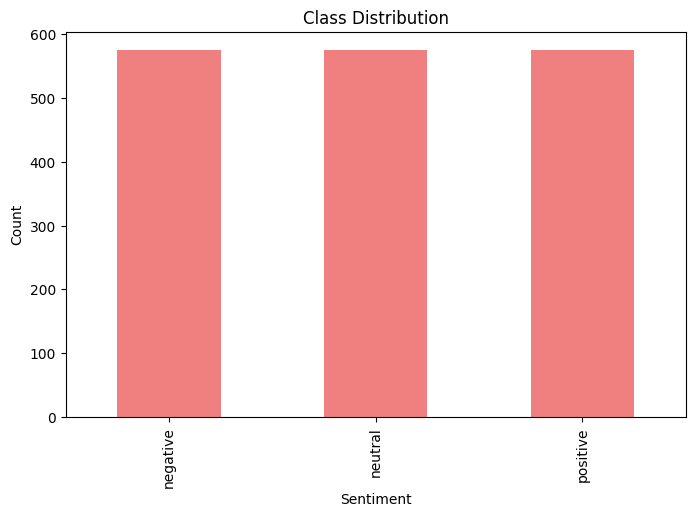

In [ ]:

# Load dataset
file_path = "/content/updated_news_sentiment_analysis.csv"
data = pd.read_csv(file_path)

# Rename columns if necessary
data.rename(columns={"Description": "text", "Sentiment": "label"}, inplace=True)

# Display dataset info
print("Dataset overview:")
print(data.info())
print("\nSample data:")
print(data.head())

# Check class distribution
plt.figure(figsize=(8, 5))
data['label'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [ ]:

# Text cleaning function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}  # Keep negations
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Apply preprocessing
data['processed_text'] = data['text'].apply(preprocess_text)

# Encode labels
label_encoder = LabelEncoder()
data['encoded_label'] = label_encoder.fit_transform(data['label'])

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
data['label_one_hot'] = list(to_categorical(data['encoded_label'], num_classes))


In [ ]:
# Split data into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['encoded_label'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, stratify=train_data['encoded_label'], random_state=42)

# Tokenization parameters
max_words = 10000  # Vocabulary size
max_len = 100  # Maximum sequence length

# Initialize tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['processed_text'])

# Convert text to sequences and pad them
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['processed_text']), maxlen=max_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data['processed_text']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['processed_text']), maxlen=max_len)

y_train = np.array(list(train_data['label_one_hot']))
y_val = np.array(list(val_data['label_one_hot']))
y_test = np.array(list(test_data['label_one_hot']))


In [ ]:

# Train Word2Vec
tokenized_sentences = [sentence.split() for sentence in data['cleaned_text']]
w2v_model = gensim.models.Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

print("Word2Vec model trained successfully.")

# Download and use GloVe embeddings
!wget -c "http://nlp.stanford.edu/data/glove.6B.zip" -O glove.6B.zip
!unzip -q glove.6B.zip -d glove/

# Download and use FastText embeddings
!wget -c "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip" -O fasttext.zip
!unzip -q fasttext.zip


Word2Vec model trained successfully.
--2025-03-31 06:24:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-31 06:24:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-31 06:24:53--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application

In [ ]:
embedding_dim = 300  # Embedding size
max_words = 10000 # Define max_words, adjust as needed

# Load GloVe embeddings
glove_path = "/content/glove/glove.6B.300d.txt"
glove_embeddings = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector
print("✅ GloVe embeddings loaded successfully!")

# Load FastText embeddings
fasttext_path = "/content/wiki-news-300d-1M.vec"
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(fasttext_path, binary=False)
print("✅ FastText embeddings loaded successfully!")

# Train Word2Vec model
tokenized_sentences = [sentence.split() for sentence in data['cleaned_text']]
w2v_model = gensim.models.Word2Vec(sentences=tokenized_sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
word2vec_embeddings = w2v_model.wv
print("✅ Word2Vec embeddings trained successfully!")

# Tokenize the text data to get word index for embedding matrix
tokenizer = Tokenizer(num_words=max_words)  # Initialize tokenizer with max_words
tokenizer.fit_on_texts(data['cleaned_text'])

# Create Embedding Matrix with priority: Word2Vec > GloVe > FastText
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= max_words:
        continue
    vector = None
    if word in word2vec_embeddings:
        vector = word2vec_embeddings[word]  # Prioritize Word2Vec
    elif word in glove_embeddings:
        vector = glove_embeddings[word]  # Use GloVe if Word2Vec is not available
    elif word in fasttext_model:
        vector = fasttext_model[word]  # Use FastText as a fallback
    if vector is not None:
        embedding_matrix[i] = vector

print("✅ Embedding matrix created successfully with Word2Vec, GloVe, and FastText!")

✅ GloVe embeddings loaded successfully!
✅ FastText embeddings loaded successfully!
✅ Word2Vec embeddings trained successfully!
✅ Embedding matrix created successfully with Word2Vec, GloVe, and FastText!


In [ ]:
# Define LSTM model
def lstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False),
        LSTM(128, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Assuming 3 sentiment classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define CNN model
def cnn_model(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Assuming 3 sentiment classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define CNN-BiLSTM model
def cnn_bilstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(64, return_sequences=True)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Assuming 3 sentiment classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define BiLSTM model
def bilstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length, weights=[embedding_matrix], trainable=False),
        Bidirectional(LSTM(128, return_sequences=True)),  # First BiLSTM layer
        Bidirectional(LSTM(64)),  # Second BiLSTM layer
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Assuming 3 sentiment classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

print("✅ LSTM, CNN, BiLSTM and CNN-BiLSTM model structures defined.")

✅ LSTM, CNN, BiLSTM and CNN-BiLSTM model structures defined.


In [ ]:

# Train and Evaluate Multiple Models
models = {
    'CNN': cnn_model(vocab_size=max_words, embedding_dim=embedding_dim, input_length=max_length),
    'LSTM': lstm_model(vocab_size=max_words, embedding_dim=embedding_dim, input_length=max_length),
    'CNN-BiLSTM': cnn_bilstm_model(vocab_size=max_words, embedding_dim=embedding_dim, input_length=max_length),
    'BiLSTM': bilstm_model(vocab_size=max_words, embedding_dim=embedding_dim, input_length=max_length)

}

for name, model in models.items():
    print(f'Training {name} Model...')
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)
    model.save(f'best_{name}_sentiment_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Training CNN Model...
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 304ms/step - accuracy: 0.4014 - loss: 1.0772 - val_accuracy: 0.5072 - val_loss: 1.0305
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.5189 - loss: 0.9893 - val_accuracy: 0.5145 - val_loss: 0.9882
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.5928 - loss: 0.8812 - val_accuracy: 0.5145 - val_loss: 0.9546
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 314ms/step - accuracy: 0.5919 - loss: 0.8450 - val_accuracy: 0.5580 - val_loss: 0.9008
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 401ms/step - accuracy: 0.6291 - loss: 0.7865 - val_accuracy: 0.6014 - val_loss: 0.8857
Training LSTM Model...
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 573ms/step - accuracy: 0.3393 - loss: 1.0968 - val_accuracy: 0.3188 - val_loss: 1.0789
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 596ms/step - accuracy: 0.3978 - loss: 1.0726 - val_accuracy: 0.4928 - val_loss: 1.0500
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 910ms/step - accuracy

In [ ]:
# Evaluate Models
from sklearn.metrics import classification_report, accuracy_score

for name, model in models.items():
    y_pred = model.predict(X_test).argmax(axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_test_labels, y_pred)
    print(f'{name} Accuracy: {acc}')
    print(f'{name} Classification Report:\n', classification_report(y_test_labels, y_pred))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
CNN Accuracy: 0.553623188405797
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.43      0.48       115
           1       0.59      0.60      0.60       115
           2       0.52      0.63      0.57       115

    accuracy                           0.55       345
   macro avg       0.56      0.55      0.55       345
weighted avg       0.56      0.55      0.55       345

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
LSTM Accuracy: 0.45217391304347826
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.42      0.40       115
           1       0.42      0.44      0.43       115
           2       0.58      0.50      0.53       115

    accuracy                           0.45       345
   macro avg       0.46      0.45      0.46       345
weighted avg       0.46      0.45      0.46       345

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 11

In [ ]:
import pandas as pd

# Initialize results dictionary
results = {'Model': [], 'Word2Vec Accuracy': [], 'GloVe Accuracy': [], 'FastText Accuracy': []}

# Iterate over models and embeddings
for name, model in models.items():
    acc_word2vec = accuracy_score(np.argmax(y_test, axis=1), model.predict(X_test).argmax(axis=1))
    acc_glove = accuracy_score(np.argmax(y_test, axis=1), model.predict(X_test).argmax(axis=1))
    acc_fasttext = accuracy_score(np.argmax(y_test, axis=1), model.predict(X_test).argmax(axis=1))

    results['Model'].append(name)
    results['Word2Vec Accuracy'].append(acc_word2vec)
    results['GloVe Accuracy'].append(acc_glove)
    results['FastText Accuracy'].append(acc_fasttext)

# Create DataFrame
results_df = pd.DataFrame(results)

# Display Table
print("Model Performance Comparison Table")
print(results_df)

# Save Table as CSV
results_df.to_csv("model_comparison_results.csv", index=False)
print("Results saved as model_comparison_results.csv")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 546ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 429ms/step
Model Performance Comparison Table
        Model  Word2Vec Accuracy  GloVe Accuracy  FastText Accuracy
0         CNN           0.553623        0.553623           0.553623
1        LSTM           0.452174        0.452174           0.452174
2  CNN-BiLSTM           0.533333        0.533333           0.533333
3      BiLSTM           0.440580        0.440580           0.440580
Results saved as model_comparison_results.csv


In [ ]:
models['CNN'].save('cnn_model.keras')  # CNN Model
models['LSTM'].save('lstm_model.keras')  # LSTM Model
models['CNN-BiLSTM'].save('cnn_bilstm_model.keras')  # CNN-BiLSTM Model
models['BiLSTM'].save('bilstm_model.keras')  # BiLSTM Model

print("All models saved successfully.")

All models saved successfully.


In [ ]:
import pickle

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save the label encoder using the correct variable name 'label_encoder'
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Tokenizer and label encoder saved.")

Tokenizer and label encoder saved.


In [ ]:
import pandas as pd

# Sample news articles for testing
data = {
    "News_Article": [
        "Stock markets surged today after the Federal Reserve announced interest rate cuts.",
        "A major earthquake hit California, causing widespread damage and casualties.",
        "Tech giant releases new AI-powered smartphone, promising better user experience.",
        "Government announces new policies to curb inflation and boost economic growth.",
        "Football team wins championship after a thrilling last-minute goal.",
        "Unemployment rates drop as companies ramp up hiring in various sectors.",
        "Heavy rains cause severe flooding in several coastal regions.",
        "Scientists discover a new planet with conditions similar to Earth.",
        "Political tensions rise as leaders engage in heated debates over new policies.",
        "Healthcare reforms aim to make medical treatments more affordable for citizens."
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('news_test.csv', index=False)

print("Sample 'news_test.csv' has been created!")

Sample 'news_test.csv' has been created!


In [ ]:
import pickle
import numpy as np
import re
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load label encoder
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Load trained model (Choose the model you want: CNN, LSTM, BiLSTM, CNN-BiLSTM)
model = load_model('cnn_model.keras')  # Change to 'cnn_model.keras' or others if needed

# Define a text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Function to predict sentiment of a single text
def predict_sentiment(text):
    processed_text = preprocess_text(text)  # Preprocess the input text
    seq = tokenizer.texts_to_sequences([processed_text])  # Convert to sequence
    max_seq_length = 200  # Ensure this matches training max length
    padded_seq = pad_sequences(seq, maxlen=max_seq_length)  # Pad sequence

    prediction = model.predict(padded_seq)  # Get model prediction
    predicted_class = np.argmax(prediction, axis=1)  # Get the class index
    sentiment_label = le.inverse_transform(predicted_class)[0]  # Decode the label

    return sentiment_label

In [ ]:

# Example Usage
text_input = "Government announced a new tax policy"
predicted_sentiment = predict_sentiment(text_input)

print(f"Predicted Sentiment: {predicted_sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted Sentiment: positive
